## **<h3 align="center"> Deep Learning - Project </h3>**
# **<h3 align="center"> Phylum Mollusca - Zo </h3>**
**Group 4 members:**<br>
Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Steven Carlson - 20240554@novaims.unl.pt - 20240554<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub - 20240505@novaims.unl.pt - 20240505<br>
Zofia Wojcik  - 20240654@novaims.unl.pt - 20240654<br>

# Table of Contents
* [1. Introduction](#intro)
* [2. Setup](#setup)
* [3. Data Loading](#dataloading)
* [4. Image Preprocessing](#imagepreprocessing)
* [5. Neural Networks Models](#nnmodels)
    * [5.1. Custom Sequential](#customseq)
    * [5.2. MobileNetV2](#MobileNetV2)
    * [5.3. EfficientNetB0](#EfficientNetB0)
    * [5.4. InceptionV3](#InceptionV3)
* [6. Hyperparameter Tuning](#hptuning)
    * [6.1. Hyperparameter Tuning for Custom Seequential Model](#hptcustomseq)
    * [6.2. Hyperparameter Tuning for MobileNetV2](#hptMobileNetV2)
* [7. Test the Models](#test)
    * [7.1. Test Custom Sequential](#testcustomseq)
    * [7.2. Test MobileNetV2](#testMobileNetV2)

# 1. Introduction <a class="anchor" id="intro"></a>

In this third notebook, we will preprocess images from the **Mollusca** phylum and develop a deep learning model to accurately classify them at the family level.

# 2. Setup <a class="anchor" id="setup"></a>
In this section, we will import the necessary libraries that will be used throughout the notebook. These libraries will help with data handling and image processing.

In [ ]:
# Standard libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random, itertools

# sklearn libraries
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow and Keras libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, smart_resize
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, InceptionV3
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Libraries for image processing
from glob import glob
from PIL import Image

2025-04-22 18:42:13.604838: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 3. Data Loading <a class="anchor" id="dataloading"></a>

Let's open the train and test for Mollusca Phylum.

In [2]:
# Load the DataFrame from the CSV file
mollusca_train = pd.read_csv("train_test_splits/Mollusca_train.csv")
mollusca_train.head(3)

eol_content_id  eol_page_id   kingdom    phylum     family  \
0        30003937     46473744  animalia  mollusca  cardiidae   
1         2744855       449459  animalia  mollusca  unionidae   
2        12835846     46454284  animalia  mollusca    conidae   

                                           file_path  
0  mollusca_cardiidae/30003937_46473744_eol-full-...  
1  mollusca_unionidae/2744855_449459_eol-full-siz...  
2  mollusca_conidae/12835846_46454284_eol-full-si...

In [3]:
# Load the DataFrame from the CSV file
mollusca_test = pd.read_csv("train_test_splits/Mollusca_test.csv")
mollusca_test.head(3)

eol_content_id  eol_page_id   kingdom    phylum      family  \
0        22271558     46454284  animalia  mollusca     conidae   
1        12800653      4792502  animalia  mollusca  haliotidae   
2        13998439     46473744  animalia  mollusca   cardiidae   

                                           file_path  
0  mollusca_conidae/22271558_46454284_eol-full-si...  
1  mollusca_haliotidae/12800653_4792502_eol-full-...  
2  mollusca_cardiidae/13998439_46473744_eol-full-...

In [4]:
mollusca_train.shape, mollusca_test.shape

((159, 6), (40, 6))

Number of training examples per family in Mollusca phylum:

In [5]:
mollusca_train['family'].value_counts()

family
cardiidae     48
unionidae     39
conidae       24
haliotidae    24
zonitidae     24
Name: count, dtype: int64

Number of test examples per family:

In [6]:
mollusca_test['family'].value_counts()

family
cardiidae     12
unionidae     10
conidae        6
haliotidae     6
zonitidae      6
Name: count, dtype: int64

# 4. Image Preprocessing <a class="anchor" id="imagepreprocessing"></a>

### What Is `ImageDataGenerator`?

`ImageDataGenerator` is a Keras utility that handles image preprocessing and real-time data augmentation during model training. It allows you to:

- **Preprocess images**: Normalize pixel values (e.g., rescale from [0, 255] to [0, 1]) or apply other transformations like standardization.
- **Augment data**: Randomly transform images (e.g., rotate, zoom, flip) to artificially increase the diversity of the training dataset and improve model generalization.
- **Generate batches**: Efficiently load images in small batches directly from disk or a DataFrame, rather than storing the entire dataset in memory.

### What Does `create_generators()` Do?

The `create_generators()` function builds and returns three Keras data generators for model training:

- **`train_generator`**: Loads training images from the `mollusca_train` DataFrame, resizes them to the specified `image_size`, applies real-time data augmentation (rotation, zoom, flipping), normalizes pixel values to [0, 1], and generates batches of images for training.

- **`val_generator`**: Loads a fixed 20% validation subset of the training data, applies the same resizing and normalization as the training generator, but no augmentation. Used to evaluate model performance during training.

- **`test_generator`**: Loads test images from the `mollusca_test` DataFrame, resizes and normalizes them, but does not apply augmentation or shuffling — ensuring predictions align with the original order of the test set.

By using `ImageDataGenerator` in combination with `flow_from_dataframe()`, you can build a scalable, memory-efficient pipeline that prepares and feeds images to your model during training, validation, and testing.


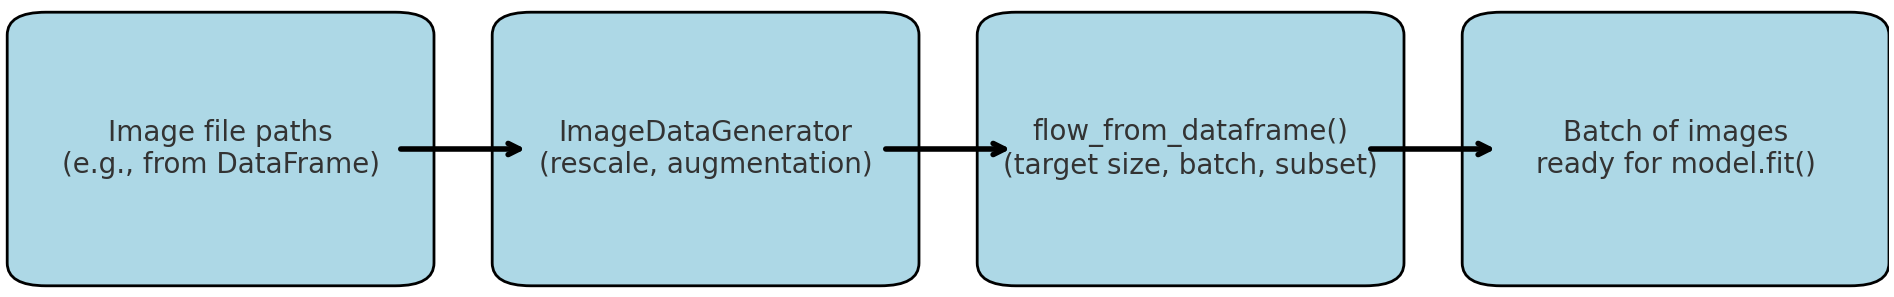

In [ ]:
# Directory where the images are stored
image_root_dir = os.path.join("rare_species")

# Prepend full image path to each file_path
mollusca_train['filepath'] = mollusca_train['file_path'].apply(lambda x: os.path.join(image_root_dir, x))
mollusca_test['filepath'] = mollusca_test['file_path'].apply(lambda x: os.path.join(image_root_dir, x))

# Data generator for TRAINING images (includes augmentation)
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,         # Normalize pixel values from [0, 255] → [0, 1]
    rotation_range=15,         # Randomly rotate images by up to 15 degrees 
    zoom_range=0.1,            # Random zoom inside image (10%) 
    horizontal_flip=True,      # Randomly flip images horizontally 
    validation_split=0.2       # Reserve 20% of training data for validation 
)

# Data generator for TEST images (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Function to create generators based on image size and batch size
def create_generators(image_size=(128, 128), batch_size=16):
    train_generator = train_datagen.flow_from_dataframe(
            dataframe=mollusca_train,         # DataFrame with image filepaths and labels
            x_col='filepath',                 # Column with full path to images
            y_col='family',                   # Column with class labels (family)
            target_size=image_size,           # Resize all images to this size
            class_mode='categorical',         # One-hot encode class labels
            batch_size=batch_size,            # Load this many images per batch
            subset='training',                # Use the training subset (80%)
            shuffle=True,                     # Shuffle the data for training
            seed=4                            # For reproducibility
    )

    val_generator = train_datagen.flow_from_dataframe(
            dataframe=mollusca_train,         # DataFrame with image filepaths and labels
            x_col='filepath',                 # Column with full path to images
            y_col='family',                   # Column with class labels (family)
            target_size=image_size,           # Resize all images to this size
            class_mode='categorical',         # One-hot encode class labels
            batch_size=batch_size,            # Load this many images per batch
            subset='validation',              # Use the training subset (80%)
            shuffle=True,                     # Shuffle the data for training
            seed=4                            # For reproducibility
    )

    test_generator = test_datagen.flow_from_dataframe(
            dataframe=mollusca_test,
            x_col='filepath',
            y_col='family',
            target_size=image_size,
            class_mode='categorical',
            batch_size=1,                     # Load one image at a time for testing
            shuffle=False                     # Do not shuffle so predictions align with input order
    )

    return train_generator, val_generator, test_generator

Side by side comparison of raw images vs preprocessed ones

In [8]:
def visualize_pipeline_processed(df, datagen, image_size=(128, 128), num_samples=5):
    """
    Shows side-by-side comparison of original vs processed (augmented + resized) images.
    
    - df: DataFrame with 'filepath' column
    - datagen: ImageDataGenerator (e.g., train_datagen)
    - image_size: size used in generator (e.g., (128, 128))
    - num_samples: number of samples to visualize
    """
    sample_df = df.sample(n=num_samples, random_state=4).reset_index(drop=True)

    # Preview generator with no labels
    preview_generator = datagen.flow_from_dataframe(
        dataframe=sample_df,
        x_col='filepath',
        y_col=None,
        class_mode=None,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    plt.figure(figsize=(10, num_samples * 2.5))

    for i in range(num_samples):
        # Original image
        original = load_img(sample_df.loc[i, 'filepath'])

        # Processed image (resized, augmented, normalized)
        processed = next(preview_generator)[0]
        processed = np.clip(processed, 0, 1)  # Ensure valid pixel range

        # Plot original
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(original)
        plt.title("Original")
        plt.axis('off')

        # Plot processed
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(processed)
        plt.title(f"Processed {image_size[0]}x{image_size[1]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 5. Neural Network Models <a class="anchor" id="nnmodels"></a>

## 5.1. Custom Sequential <a class="anchor" id="customseq"></a>

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Found 5 validated image filenames.


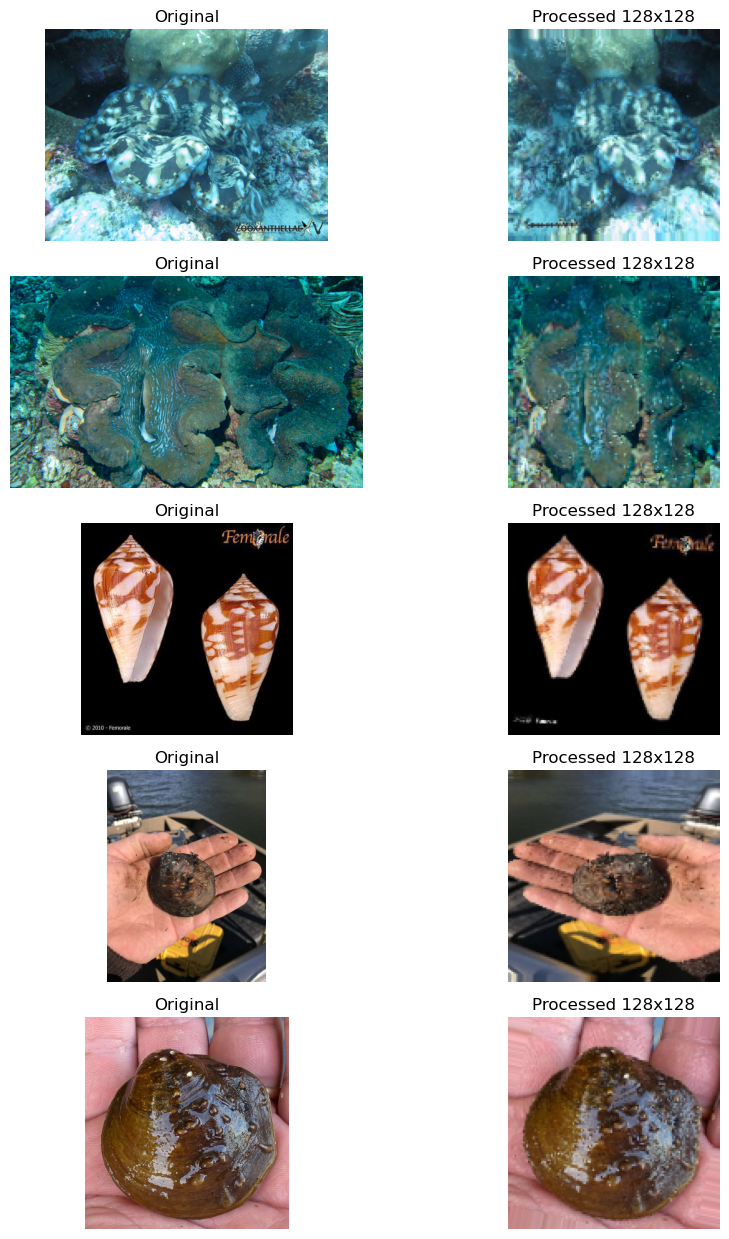

In [9]:
# Create generators for training, validation, and testing sets
train_generator, val_generator, test_generator = create_generators(image_size=(128, 128), batch_size=16)

# Visualize the data augmentation and resizing process
visualize_pipeline_processed(mollusca_train, train_datagen, image_size=(128, 128), num_samples=5)

In [10]:
model1 = models.Sequential([
    layers.Input(shape=(128, 128, 3)),  # RGB images

    # Conv Block 1
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Helps prevent overfitting

    # Output Layer
    layers.Dense(5, activation='softmax')  # 5 classes
])

model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

In [11]:
history1 = model1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,   # Previously 30 and there was potential for better loss
    callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose = 1, # default (progress bar per epoch)             
    class_weight=None      # Do not adjusts loss function to rebalance classes
)
# Execution time: 3m 7.1s

Epoch 1/50
6/8 [=====================>........] - ETA: 1s - loss: 1.7318 - accuracy: 0.2708

/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


8/8 [==============================] - 11s 1s/step - loss: 1.7158 - accuracy: 0.2656 - val_loss: 1.4431 - val_accuracy: 0.3871
Epoch 2/50
8/8 [==============================] - 9s 1s/step - loss: 1.4815 - accuracy: 0.4141 - val_loss: 1.1064 - val_accuracy: 0.5161
Epoch 3/50
8/8 [==============================] - 8s 961ms/step - loss: 1.4526 - accuracy: 0.5078 - val_loss: 1.1135 - val_accuracy: 0.5806
Epoch 4/50
8/8 [==============================] - 9s 1s/step - loss: 1.3321 - accuracy: 0.4688 - val_loss: 1.0239 - val_accuracy: 0.6452
Epoch 5/50
8/8 [==============================] - 10s 1s/step - loss: 1.2998 - accuracy: 0.4609 - val_loss: 0.9155 - val_accuracy: 0.7097
Epoch 6/50
8/8 [==============================] - 9s 1s/step - loss: 1.1036 - accuracy: 0.5938 - val_loss: 0.8649 - val_accuracy: 0.6774
Epoch 7/50
8/8 [==============================] - 9s 1s/step - loss: 0.9669 - accuracy: 0.6250 - val_loss: 0.8288 - val_accuracy: 0.7419
Epoch 8/50
8/8 [==============================]

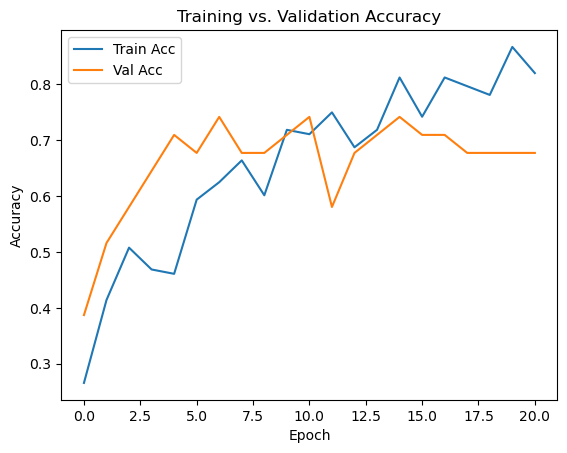

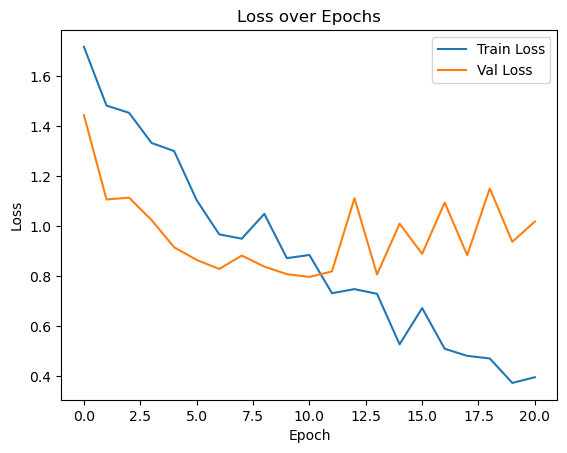

In [12]:
# plot the results
plt.plot(history1.history['accuracy'], label='Train Acc')
plt.plot(history1.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs. Validation Accuracy')
plt.show()

# Loss
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

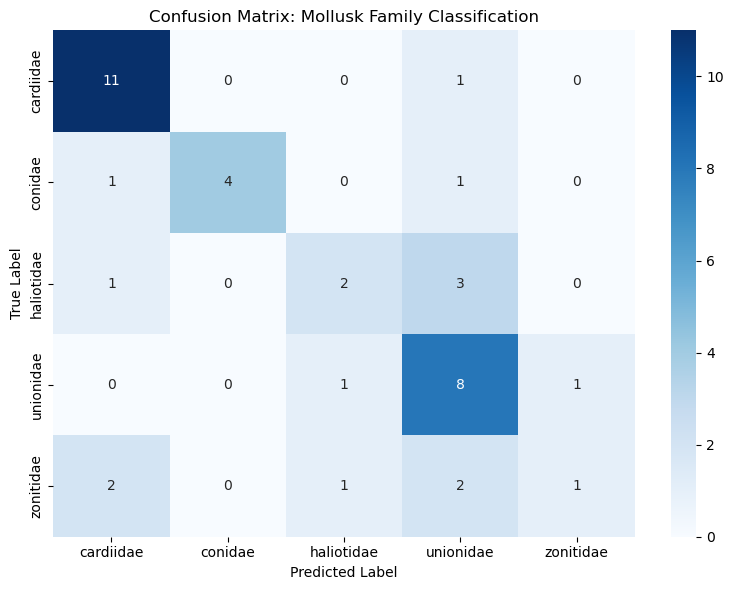

In [13]:
# Get true labels from test generator
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on test data
y_pred_probs = model1.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## 5.2. MobileNetV2 <a class="anchor" id="MobileNetV2"></a>

### When to Freeze or Unfreeze Layers in Transfer Learning

When using a pretrained model (like VGG16 or InceptionV3), you can choose between **freezing** or **unfreezing** layers depending on your data and goals.

---

#### Freeze All Layers (Feature Extraction)
- Use the pretrained model as a **fixed feature extractor**.
- Only train a new classifier head on top (Dense + Dropout + Softmax).
- **Best when:**
  - You have a **small dataset**
  - Your images are **similar to ImageNet**
  - You want a **quick and stable baseline**

---

#### Unfreeze Some Layers (Fine-Tuning)
- After training the top classifier, unfreeze the **last few layers** of the pretrained model.
- Allows the model to **adapt** more deeply to your specific data.
- **Best when:**
  - You have **more data**
  - Your images are **very different from ImageNet** (e.g., rare species, medical, satellite)
  - You want **higher accuracy**

---

In [14]:
# Load base model without top layer
base_model = MobileNetV2(
    input_shape=(128, 128, 3), # Match your resized image shape
    include_top=False,         # Don't include the original classifier
    weights='imagenet'         # Use ImageNet-pretrained weights 
)

# Freeze base model so we only train the new layers for now
base_model.trainable = False

# Build custom model
model2 = models.Sequential([
    base_model,                                # Feature extractor
    layers.GlobalAveragePooling2D(),           # Pool over spatial dimensions
    layers.Dropout(0.3),                       # Regularization layer
    layers.Dense(128, activation='relu'),      # Fully connected layer
    layers.Dense(5, activation='softmax')      # Output layer (5 mollusk families)
])

# Compile model
model2.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary for your viewing pleasure
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 2422597 (9.24 MB)
Trainable params: 1646

In [ ]:
history2 = model2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,           # Start small, increase if needed
    callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1            # default (progress bar per epoch) 
)
# Execution time: 7m 52.1s

/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1/50
8/8 [==============================] - 16s 2s/step - loss: 2.0102 - accuracy: 0.2422 - val_loss: 1.7830 - val_accuracy: 0.3226
Epoch 2/50
8/8 [==============================] - 9s 1s/step - loss: 1.6421 - accuracy: 0.3047 - val_loss: 1.4451 - val_accuracy: 0.4194
Epoch 3/50
8/8 [==============================] - 11s 1s/step - loss: 1.3044 - accuracy: 0.4375 - val_loss: 1.1220 - val_accuracy: 0.6452
Epoch 4/50
8/8 [==============================] - 9s 964ms/step - loss: 1.1930 - accuracy: 0.5703 - val_loss: 0.8958 - val_accuracy: 0.7097
Epoch 5/50
8/8 [==============================] - 9s 1s/step - loss: 0.9854 - accuracy: 0.6250 - val_loss: 0.7657 - val_accuracy: 0.7419
Epoch 6/50
8/8 [==============================] - 8s 1s/step - loss: 0.8722 - accuracy: 0.6719 - val_loss: 0.6271 - val_accuracy: 0.8387
Epoch 7/50
8/8 [==============================] - 9s 1s/step - loss: 0.7728 - accuracy: 0.6797 - val_loss: 0.6285 - val_accuracy: 0.7742
Epoch 8/50
8/8 [====================

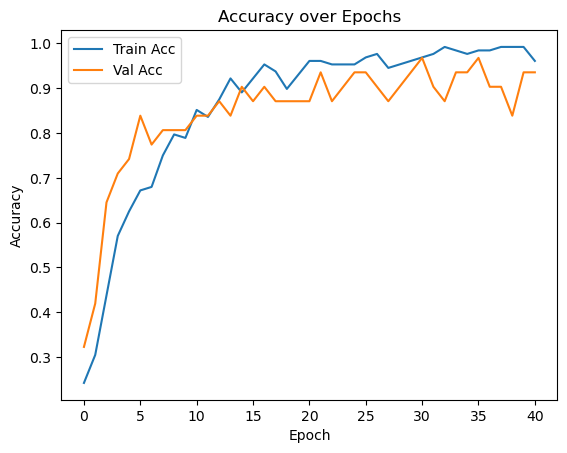

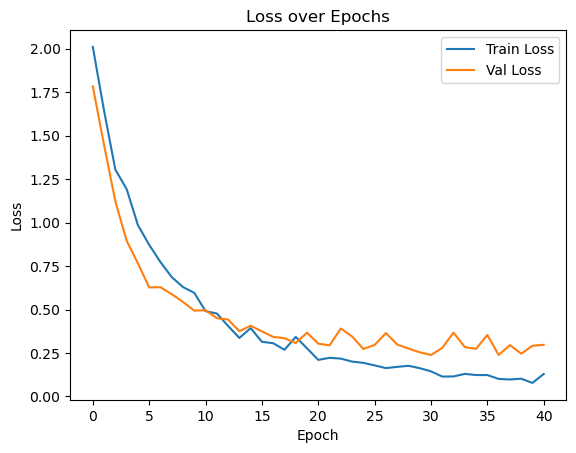

In [16]:
# Accuracy
plt.plot(history2.history['accuracy'], label='Train Acc')
plt.plot(history2.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

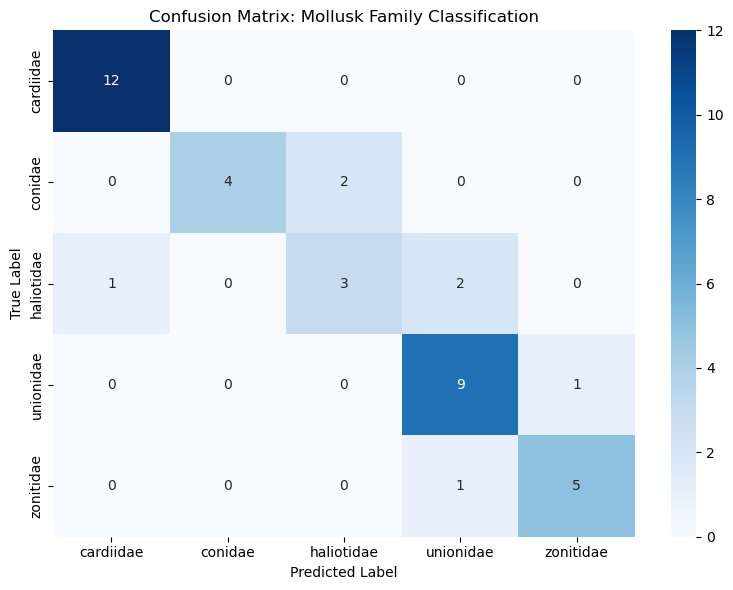

In [17]:
# Get true labels from test generator
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on test data
y_pred_probs = model2.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## 5.3. EfficientNetB0 <a class="anchor" id="EfficientNetB0"></a>

Need image size of 224x224

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Found 5 validated image filenames.


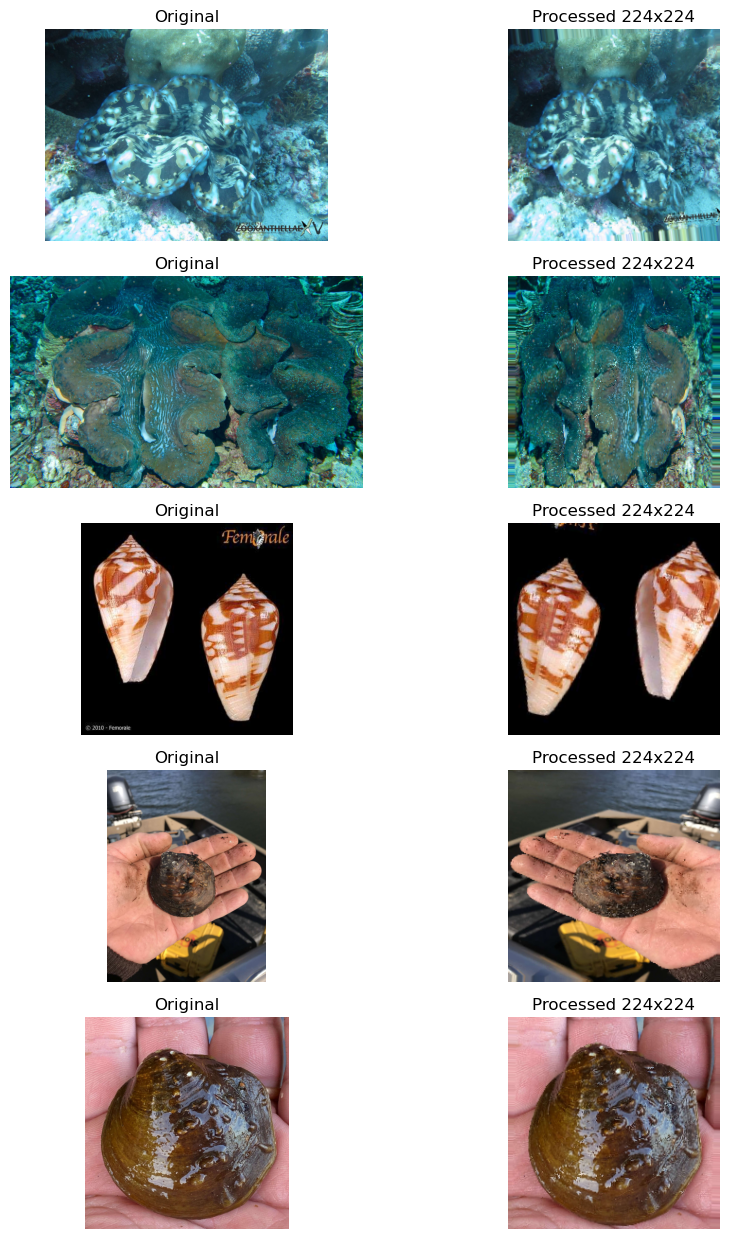

In [18]:
# Create generators for training, validation, and testing sets
train_generator, val_generator, test_generator = create_generators(image_size=(224, 224), batch_size=16)

# Visualize the data augmentation and resizing process
visualize_pipeline_processed(mollusca_train, train_datagen, image_size=(224, 224), num_samples=5)

In [19]:
# Load EfficientNetB0 without the top classification layer
base_model = EfficientNetB0(
    input_shape=(224, 224, 3),   # match EfficientNetB0 default input size
    include_top=False,           # Remove the original classifier head
    weights='imagenet'           # Use pre-trained ImageNet weights
)

# Freeze the base model to use it as a fixed feature extractor
base_model.trainable = False

# Build your custom classifier head
model3 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # 5 mollusk families
])

# Compile the model
model3.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               163968    
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 4214184 (16.08 MB)
Trainable params: 164

In [ ]:
history3 = model3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)
# Ececution time: 3m 54.1s

Epoch 1/50
3/8 [==========>...................] - ETA: 9s - loss: 1.6025 - accuracy: 0.2292 

/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


8/8 [==============================] - 33s 3s/step - loss: 1.6017 - accuracy: 0.2500 - val_loss: 1.6843 - val_accuracy: 0.2581
Epoch 2/50
8/8 [==============================] - 20s 3s/step - loss: 1.5599 - accuracy: 0.2734 - val_loss: 1.6943 - val_accuracy: 0.2581
Epoch 3/50
8/8 [==============================] - 20s 2s/step - loss: 1.5496 - accuracy: 0.3047 - val_loss: 1.7059 - val_accuracy: 0.2581
Epoch 4/50
8/8 [==============================] - 20s 3s/step - loss: 1.5457 - accuracy: 0.2969 - val_loss: 1.7150 - val_accuracy: 0.2581
Epoch 5/50
8/8 [==============================] - 19s 2s/step - loss: 1.5742 - accuracy: 0.2734 - val_loss: 1.7084 - val_accuracy: 0.2581
Epoch 6/50
8/8 [==============================] - 20s 3s/step - loss: 1.5570 - accuracy: 0.2891 - val_loss: 1.7099 - val_accuracy: 0.2581
Epoch 7/50
8/8 [==============================] - 19s 2s/step - loss: 1.5465 - accuracy: 0.3203 - val_loss: 1.6954 - val_accuracy: 0.2581
Epoch 8/50
8/8 [=============================

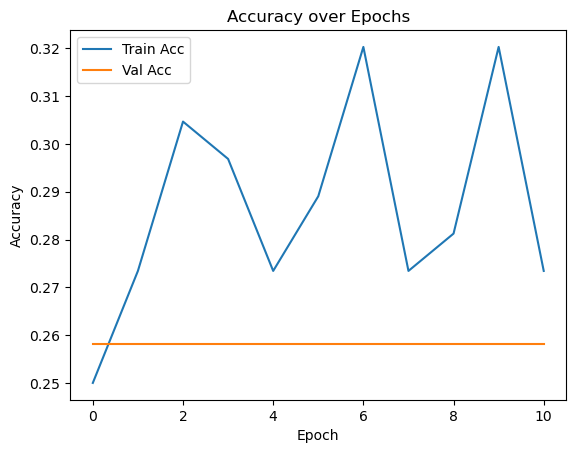

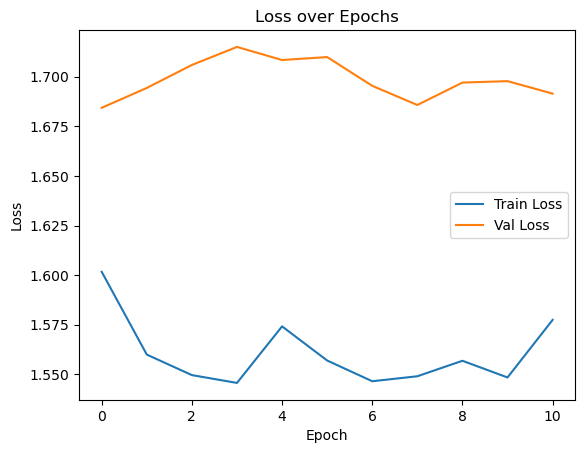

In [21]:
# Accuracy
plt.plot(history3.history['accuracy'], label='Train Acc')
plt.plot(history3.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

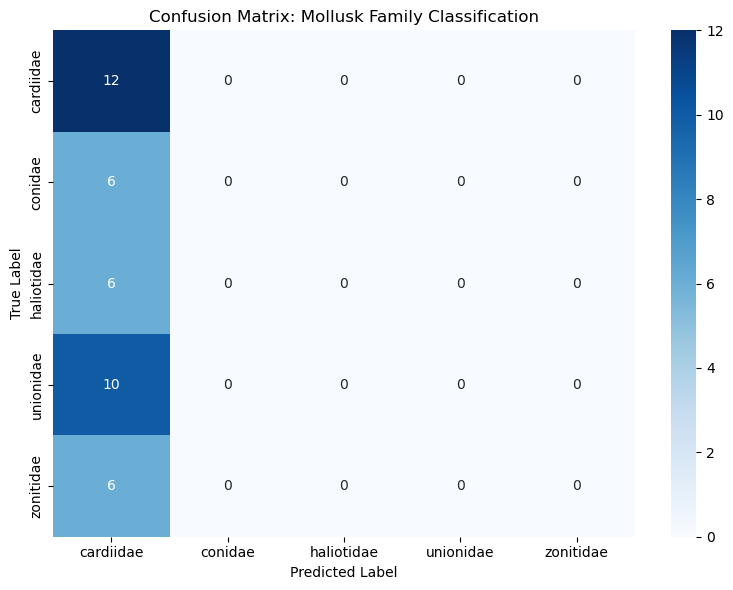

In [22]:
# Get true labels from test generator
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on test data
y_pred_probs = model3.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

## 5.4. InceptionV3 <a class="anchor" id="InceptionV3"></a>

In [23]:
# Create generators for training, validation, and testing sets
train_generator, val_generator, test_generator = create_generators(image_size=(139,139), batch_size=16)

# Visualize the data augmentation and resizing process
visualize_pipeline_processed(mollusca_train, train_datagen, image_size=(139,139), num_samples=5)

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Found 5 validated image filenames.


In [24]:
# Load InceptionV3 base model WITHOUT the top classifier
base_model = InceptionV3(
    input_shape=(139, 139, 3),   # Must be at least 139x139
    include_top=False,           # Remove the original classifier
    weights='imagenet'           # Use pretrained ImageNet weights
)

# Unfreeze last 50 layers for fine-tuning
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Build the custom classification head
model4 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # Assuming 5 mollusk families
])

# Compile the model
model4.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dense_7 (Dense)             (None, 5)                 645       
                                                                 
Total params: 22065701 (84.17 MB)
Trainable params: 7436229 (28.37 MB)
Non-trainable params: 14629472 (55.81 MB)
_______

In [ ]:
# Train the model
history4 = model4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)
# Execution time: 16m 1.4s

Epoch 1/50
7/8 [=========================>....] - ETA: 1s - loss: 1.4083 - accuracy: 0.3750

/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


8/8 [==============================] - 29s 3s/step - loss: 1.3715 - accuracy: 0.4141 - val_loss: 1.3979 - val_accuracy: 0.5806
Epoch 2/50
8/8 [==============================] - 17s 2s/step - loss: 0.7368 - accuracy: 0.8203 - val_loss: 1.3417 - val_accuracy: 0.5806
Epoch 3/50
8/8 [==============================] - 17s 2s/step - loss: 0.4637 - accuracy: 0.8906 - val_loss: 1.1933 - val_accuracy: 0.7097
Epoch 4/50
8/8 [==============================] - 17s 2s/step - loss: 0.3230 - accuracy: 0.9062 - val_loss: 1.0250 - val_accuracy: 0.6774
Epoch 5/50
8/8 [==============================] - 17s 2s/step - loss: 0.2005 - accuracy: 0.9688 - val_loss: 0.7695 - val_accuracy: 0.7742
Epoch 6/50
8/8 [==============================] - 17s 2s/step - loss: 0.1356 - accuracy: 0.9766 - val_loss: 0.6311 - val_accuracy: 0.7742
Epoch 7/50
8/8 [==============================] - 17s 2s/step - loss: 0.1178 - accuracy: 0.9688 - val_loss: 0.4876 - val_accuracy: 0.8387
Epoch 8/50
8/8 [=============================

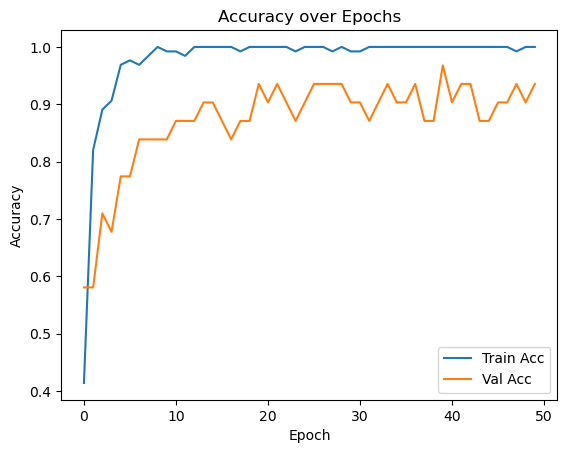

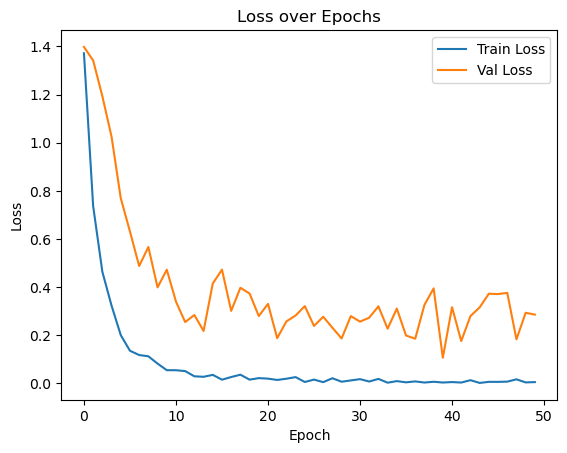

In [26]:
# Accuracy
plt.plot(history4.history['accuracy'], label='Train Acc')
plt.plot(history4.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

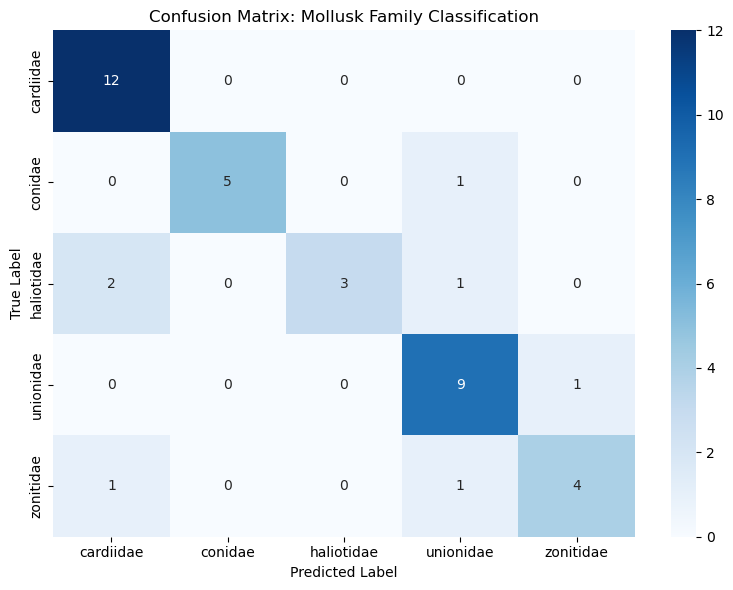

In [27]:
# Get true labels from test generator
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on test data
y_pred_probs = model4.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# 6. Hyperparameter tuning <a class="anchor" id="hptuning"></a>

## 6.1. Hyperparameter tuning for Custom Sequential Model <a class="anchor" id="hptcustomseq"></a>

In [ ]:
# Hyperparameter Grid 
optimizers_list = ['adam', 'rmsprop', 'sgd']
learning_rates = [1e-3, 1e-4, 1e-5]
dropouts = [0.2, 0.3, 0.4, 0.5]
dense_units = [64, 128, 256]
batch_sizes = [8, 16, 32]
image_sizes = [(128, 128), (224, 224)]
use_weights = [True, False]  # class imbalance handling

# Create all combinations
all_combinations = list(itertools.product(
    optimizers_list, learning_rates, dropouts,
    dense_units, batch_sizes, image_sizes, use_weights
))

random.seed(4)
sampled_combos = random.sample(all_combinations, k=50)

results = []

for i, (opt_name, lr, dropout, units, batch_size, image_size, use_weights) in enumerate(sampled_combos):
    print(f"\nCombo {i+1}/{len(sampled_combos)}: "
          f"opt={opt_name}, lr={lr}, dropout={dropout}, units={units}, "
          f"batch_size={batch_size}, image_size={image_size}, class_weight={use_weights}")

    # Create data generators
    train_generator, val_generator, _ = create_generators(
        image_size=image_size, batch_size=batch_size
    )

    # Build custom CNN
    model = models.Sequential([
        layers.Input(shape=(image_size[0], image_size[1], 3)),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(5, activation='softmax')
    ])

    # Optimizer
    if opt_name == 'adam':
        opt = optimizers.Adam(learning_rate=lr)
    elif opt_name == 'rmsprop':
        opt = optimizers.RMSprop(learning_rate=lr)
    elif opt_name == 'sgd':
        opt = optimizers.SGD(learning_rate=lr, momentum=0.9)

    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Compute class weights 
    class_weight = None
    if use_weights:
        y_labels = train_generator.classes  # Extract class indices
        class_weights_array = compute_class_weight(class_weight='balanced',
                                                   classes=np.unique(y_labels),
                                                   y=y_labels)
        class_weight = dict(enumerate(class_weights_array))

    # Train the model 
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
        class_weight=class_weight,  # Optional
        verbose=0
    )

    # Record best val accuracy
    val_acc = max(history.history['val_accuracy'])
    print(f"Best Val Acc: {val_acc:.4f}")

    results.append({
        'optimizer': opt_name,
        'lr': lr,
        'dropout': dropout,
        'units': units,
        'batch_size': batch_size,
        'image_size': image_size,
        'class_weight': use_weights,
        'val_acc': val_acc
    })

# Create leaderboard 
df_results = pd.DataFrame(results).sort_values(by='val_acc', ascending=False)
print("\nTop Configs:")
print(df_results.head(10))

# Execution time: 414m 22.4s


Combo 1/50: opt=rmsprop, lr=0.001, dropout=0.3, units=128, batch_size=8, image_size=(224, 224), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 2/50: opt=rmsprop, lr=0.0001, dropout=0.3, units=64, batch_size=32, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7097

Combo 3/50: opt=adam, lr=0.0001, dropout=0.3, units=256, batch_size=16, image_size=(224, 224), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 4/50: opt=rmsprop, lr=1e-05, dropout=0.4, units=128, batch_size=16, image_size=(224, 224), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 5/50: opt=sgd, lr=0.001, dropout=0.5, units=64, batch_size=32, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 6/50: opt=adam, lr=1e-05, dropout=0.2, units=256, batch_size=16, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 7/50: opt=adam, lr=0.0001, dropout=0.3, units=64, batch_size=16, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7097

Combo 8/50: opt=adam, lr=0.001, dropout=0.5, units=256, batch_size=16, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 9/50: opt=adam, lr=0.001, dropout=0.3, units=64, batch_size=16, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 10/50: opt=rmsprop, lr=1e-05, dropout=0.4, units=256, batch_size=16, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 11/50: opt=sgd, lr=0.0001, dropout=0.5, units=64, batch_size=32, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.3226

Combo 12/50: opt=rmsprop, lr=0.0001, dropout=0.2, units=128, batch_size=16, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 13/50: opt=adam, lr=0.001, dropout=0.5, units=128, batch_size=8, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7097

Combo 14/50: opt=rmsprop, lr=0.001, dropout=0.2, units=128, batch_size=32, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 15/50: opt=sgd, lr=0.0001, dropout=0.3, units=128, batch_size=32, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.2581

Combo 16/50: opt=sgd, lr=0.0001, dropout=0.4, units=128, batch_size=16, image_size=(224, 224), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 17/50: opt=rmsprop, lr=1e-05, dropout=0.2, units=128, batch_size=16, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7097

Combo 18/50: opt=rmsprop, lr=0.001, dropout=0.5, units=256, batch_size=8, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7097

Combo 19/50: opt=adam, lr=1e-05, dropout=0.3, units=256, batch_size=16, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7097

Combo 20/50: opt=adam, lr=0.0001, dropout=0.4, units=64, batch_size=8, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 21/50: opt=rmsprop, lr=0.001, dropout=0.4, units=256, batch_size=32, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 22/50: opt=rmsprop, lr=0.001, dropout=0.2, units=64, batch_size=16, image_size=(224, 224), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 23/50: opt=adam, lr=0.001, dropout=0.3, units=128, batch_size=16, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 24/50: opt=rmsprop, lr=0.001, dropout=0.4, units=256, batch_size=16, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 25/50: opt=rmsprop, lr=0.001, dropout=0.5, units=128, batch_size=16, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.8065

Combo 26/50: opt=adam, lr=1e-05, dropout=0.5, units=64, batch_size=8, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 27/50: opt=adam, lr=1e-05, dropout=0.3, units=128, batch_size=8, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 28/50: opt=rmsprop, lr=0.0001, dropout=0.3, units=128, batch_size=32, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 29/50: opt=rmsprop, lr=0.0001, dropout=0.2, units=128, batch_size=16, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 30/50: opt=sgd, lr=1e-05, dropout=0.5, units=256, batch_size=8, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.6129

Combo 31/50: opt=rmsprop, lr=1e-05, dropout=0.3, units=64, batch_size=16, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 32/50: opt=adam, lr=0.0001, dropout=0.2, units=256, batch_size=32, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 33/50: opt=sgd, lr=1e-05, dropout=0.4, units=128, batch_size=16, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7097

Combo 34/50: opt=rmsprop, lr=0.0001, dropout=0.5, units=64, batch_size=16, image_size=(224, 224), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.8387

Combo 35/50: opt=rmsprop, lr=1e-05, dropout=0.4, units=64, batch_size=8, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 36/50: opt=sgd, lr=0.0001, dropout=0.2, units=256, batch_size=16, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.6452

Combo 37/50: opt=rmsprop, lr=0.001, dropout=0.4, units=64, batch_size=16, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 38/50: opt=adam, lr=1e-05, dropout=0.4, units=64, batch_size=16, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.6774

Combo 39/50: opt=rmsprop, lr=0.001, dropout=0.4, units=64, batch_size=8, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.6774

Combo 40/50: opt=sgd, lr=0.001, dropout=0.4, units=256, batch_size=32, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7097

Combo 41/50: opt=rmsprop, lr=0.001, dropout=0.5, units=256, batch_size=32, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.8065

Combo 42/50: opt=adam, lr=0.0001, dropout=0.3, units=64, batch_size=8, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 43/50: opt=sgd, lr=0.0001, dropout=0.5, units=64, batch_size=16, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.5161

Combo 44/50: opt=rmsprop, lr=0.0001, dropout=0.3, units=64, batch_size=8, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 45/50: opt=adam, lr=0.001, dropout=0.2, units=128, batch_size=8, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 46/50: opt=rmsprop, lr=0.0001, dropout=0.2, units=128, batch_size=32, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Combo 47/50: opt=sgd, lr=1e-05, dropout=0.2, units=128, batch_size=32, image_size=(128, 128), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.1613

Combo 48/50: opt=rmsprop, lr=0.0001, dropout=0.3, units=256, batch_size=8, image_size=(224, 224), class_weight=True
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 49/50: opt=sgd, lr=0.0001, dropout=0.2, units=256, batch_size=32, image_size=(128, 128), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.2581

Combo 50/50: opt=adam, lr=1e-05, dropout=0.5, units=64, batch_size=8, image_size=(224, 224), class_weight=False
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7419

Top Configs:
   optimizer       lr  dropout  units  batch_size  image_size  class_weight  \
33   rmsprop  0.00010      0.5     64          16  (224, 224)         False   
24   rmsprop  0.00100      0.5    128          16  (128, 128)          True   
40   rmsprop  0.00100      0.5    256          32  (128, 128)         False   
9    rmsprop  0.00001      0.4    256          16  (224, 224)          True   
30   rmsprop  0.00001      0.3     64          16  (224, 224)          True   
28   rmsprop  0.00010      0.2    128          16  (128, 128)         False   
22      adam  0.00100      0.3    128          16  (128, 128)          True   
7       adam  0.00100      0.5    256          16  (128, 128)          True   
47   rmsprop  0.00010      0.3    256           8  (224, 224)          True   
36   rmsprop  0.00100      0.4     64          16  (128, 128)         False   

     val_acc  
33  0.838710  
24  0.806452  
40  0.806452  
9   0.774194  
30  0.774194  
28  0

## 6.2. Hyperparameter tuning for MobileNetV2<a class="anchor" id="hptMobileNetV2"></a>

In [ ]:
# Define hyperparameter grid
optimizers_list = ['adam', 'rmsprop', 'sgd']
learning_rates = [1e-3, 1e-4, 1e-5]
dropouts = [0.2, 0.3, 0.4, 0.5]
dense_units = [64, 128, 256]
unfreeze_depths = [0, 25, 50, 75]  # Include 0 to freeze all layers
batch_sizes = [8, 16, 32]
image_sizes = [(128, 128), (224, 224)]  # Test MobileNetV2 with multiple resolutions

# Create all combinations
all_combinations = list(itertools.product(
    optimizers_list, learning_rates, dropouts,
    dense_units, unfreeze_depths, batch_sizes, image_sizes
))

# Shuffle and sample a manageable batch
random.seed(4)
sampled_combos = random.sample(all_combinations, k=50)  # Sample 50 combinations

# Initialize results list
results = []

for i, (opt_name, lr, dropout, units, unfreeze, batch_size, image_size) in enumerate(sampled_combos):
    print(f"\nCombo {i+1}/{len(sampled_combos)}: "
          f"opt={opt_name}, lr={lr}, dropout={dropout}, units={units}, "
          f"unfreeze={unfreeze}, batch_size={batch_size}, image_size={image_size}")

    # Create generators for this batch_size and image_size
    train_generator, val_generator, _ = create_generators(
        image_size=image_size, batch_size=batch_size
    )

    # Load MobileNetV2 with current image_size
    base_model = MobileNetV2(
        input_shape=(image_size[0], image_size[1], 3),
        include_top=False,
        weights='imagenet'
    )

    # Freeze all layers OR fine-tune some
    if unfreeze == 0:
        base_model.trainable = False  # Freeze all layers
    else:
        base_model.trainable = True
        fine_tune_at = len(base_model.layers) - unfreeze
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

    # Build model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout),
        layers.Dense(units, activation='relu'),
        layers.Dense(5, activation='softmax')  # <-- Change to 202 if you're classifying 202 classes!
    ])

    # Select optimizer
    if opt_name == 'adam':
        opt = optimizers.Adam(learning_rate=lr)
    elif opt_name == 'rmsprop':
        opt = optimizers.RMSprop(learning_rate=lr)
    elif opt_name == 'sgd':
        opt = optimizers.SGD(learning_rate=lr, momentum=0.9)

    # Compile model
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
        verbose=0
    )

    # Record best validation accuracy
    val_acc = max(history.history['val_accuracy'])
    print(f"Best Val Acc: {val_acc:.4f}")

    results.append({
        'optimizer': opt_name,
        'lr': lr,
        'dropout': dropout,
        'units': units,
        'unfreeze': unfreeze,
        'batch_size': batch_size,
        'image_size': image_size,
        'val_acc': val_acc
    })

# Create leaderboard
df_results = pd.DataFrame(results).sort_values(by='val_acc', ascending=False)
print("\nTop Configs:")
print(df_results.head(10))

# Execution time: 362m 23.5s


Combo 1/50: opt=rmsprop, lr=0.001, dropout=0.3, units=128, unfreeze=25, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7097

Combo 2/50: opt=rmsprop, lr=0.0001, dropout=0.3, units=64, unfreeze=75, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9032

Combo 3/50: opt=adam, lr=0.0001, dropout=0.3, units=256, unfreeze=50, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9355

Combo 4/50: opt=rmsprop, lr=1e-05, dropout=0.4, units=128, unfreeze=50, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9032

Combo 5/50: opt=sgd, lr=0.001, dropout=0.5, units=64, unfreeze=50, batch_size=32, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9677

Combo 6/50: opt=adam, lr=1e-05, dropout=0.2, units=256, unfreeze=25, batch_size=32, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.8387

Combo 7/50: opt=adam, lr=0.0001, dropout=0.3, units=64, unfreeze=25, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9677

Combo 8/50: opt=adam, lr=0.001, dropout=0.5, units=256, unfreeze=25, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9355

Combo 9/50: opt=adam, lr=0.001, dropout=0.3, units=64, unfreeze=25, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.8387

Combo 10/50: opt=rmsprop, lr=1e-05, dropout=0.4, units=256, unfreeze=50, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9355

Combo 11/50: opt=sgd, lr=0.0001, dropout=0.5, units=64, unfreeze=75, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.8710

Combo 12/50: opt=rmsprop, lr=0.0001, dropout=0.2, units=128, unfreeze=25, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9677

Combo 13/50: opt=adam, lr=0.001, dropout=0.5, units=128, unfreeze=0, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9677

Combo 14/50: opt=rmsprop, lr=0.001, dropout=0.2, units=128, unfreeze=75, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.8387

Combo 15/50: opt=sgd, lr=0.0001, dropout=0.3, units=128, unfreeze=75, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 1.0000

Combo 16/50: opt=sgd, lr=0.0001, dropout=0.4, units=128, unfreeze=50, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.8710

Combo 17/50: opt=rmsprop, lr=1e-05, dropout=0.2, units=128, unfreeze=25, batch_size=32, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.8710

Combo 18/50: opt=rmsprop, lr=0.001, dropout=0.5, units=256, unfreeze=0, batch_size=32, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 1.0000

Combo 19/50: opt=adam, lr=1e-05, dropout=0.3, units=256, unfreeze=25, batch_size=32, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9032

Combo 20/50: opt=adam, lr=0.0001, dropout=0.4, units=64, unfreeze=0, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9677

Combo 21/50: opt=rmsprop, lr=0.001, dropout=0.4, units=256, unfreeze=50, batch_size=32, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 22/50: opt=rmsprop, lr=0.001, dropout=0.2, units=64, unfreeze=50, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9032

Combo 23/50: opt=adam, lr=0.001, dropout=0.3, units=128, unfreeze=25, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9355

Combo 24/50: opt=rmsprop, lr=0.001, dropout=0.4, units=256, unfreeze=25, batch_size=32, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9355

Combo 25/50: opt=rmsprop, lr=0.001, dropout=0.5, units=128, unfreeze=25, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9032

Combo 26/50: opt=adam, lr=1e-05, dropout=0.5, units=64, unfreeze=0, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 27/50: opt=adam, lr=1e-05, dropout=0.3, units=128, unfreeze=0, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7742

Combo 28/50: opt=rmsprop, lr=0.0001, dropout=0.3, units=128, unfreeze=75, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9677

Combo 29/50: opt=rmsprop, lr=0.0001, dropout=0.2, units=128, unfreeze=25, batch_size=32, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9355

Combo 30/50: opt=sgd, lr=1e-05, dropout=0.5, units=256, unfreeze=0, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.7097

Combo 31/50: opt=rmsprop, lr=1e-05, dropout=0.3, units=64, unfreeze=50, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9355

Combo 32/50: opt=adam, lr=0.0001, dropout=0.2, units=256, unfreeze=75, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9677

Combo 33/50: opt=sgd, lr=1e-05, dropout=0.4, units=128, unfreeze=25, batch_size=16, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.5806

Combo 34/50: opt=rmsprop, lr=0.0001, dropout=0.5, units=64, unfreeze=50, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9032

Combo 35/50: opt=rmsprop, lr=1e-05, dropout=0.4, units=64, unfreeze=0, batch_size=32, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.5484

Combo 36/50: opt=sgd, lr=0.0001, dropout=0.2, units=256, unfreeze=25, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.8710

Combo 37/50: opt=rmsprop, lr=0.001, dropout=0.4, units=64, unfreeze=25, batch_size=32, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9355

Combo 38/50: opt=adam, lr=1e-05, dropout=0.4, units=64, unfreeze=25, batch_size=16, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9355

Combo 39/50: opt=rmsprop, lr=0.001, dropout=0.4, units=64, unfreeze=0, batch_size=32, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9677

Combo 40/50: opt=sgd, lr=0.001, dropout=0.4, units=256, unfreeze=75, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9677

Combo 41/50: opt=rmsprop, lr=0.001, dropout=0.5, units=256, unfreeze=75, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.6129

Combo 42/50: opt=adam, lr=0.0001, dropout=0.3, units=64, unfreeze=0, batch_size=32, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9355

Combo 43/50: opt=sgd, lr=0.0001, dropout=0.5, units=64, unfreeze=25, batch_size=32, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9032

Combo 44/50: opt=rmsprop, lr=0.0001, dropout=0.3, units=64, unfreeze=0, batch_size=32, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9355

Combo 45/50: opt=adam, lr=0.001, dropout=0.2, units=128, unfreeze=0, batch_size=32, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9677

Combo 46/50: opt=rmsprop, lr=0.0001, dropout=0.2, units=128, unfreeze=75, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 1.0000

Combo 47/50: opt=sgd, lr=1e-05, dropout=0.2, units=128, unfreeze=50, batch_size=32, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.4516

Combo 48/50: opt=rmsprop, lr=0.0001, dropout=0.3, units=256, unfreeze=0, batch_size=32, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9677

Combo 49/50: opt=sgd, lr=0.0001, dropout=0.2, units=256, unfreeze=75, batch_size=8, image_size=(128, 128)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9355

Combo 50/50: opt=adam, lr=1e-05, dropout=0.5, units=64, unfreeze=25, batch_size=8, image_size=(224, 224)
Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Best Val Acc: 0.9677

Top Configs:
   optimizer      lr  dropout  units  unfreeze  batch_size  image_size  \
17   rmsprop  0.0010      0.5    256         0          32  (224, 224)   
14       sgd  0.0001      0.3    128        75           8  (224, 224)   
45   rmsprop  0.0001      0.2    128        75           8  (224, 224)   
12      adam  0.0010      0.5    128         0           8  (224, 224)   
4        sgd  0.0010      0.5     64        50          32  (224, 224)   
11   rmsprop  0.0001      0.2    128        25          16  (224, 224)   
27   rmsprop  0.0001      0.3    128        75          16  (224, 224)   
31      adam  0.0001      0.2    256        75           8  (224, 224)   
19      adam  0.0001      0.4     64         0          16  (128, 128)   
6       adam  0.0001      0.3     64        25          16  (224, 224)   

     val_acc  
17  1.000000  
14  1.000000  
45  1.000000  
12  0.967742  
4   0.967742  
11  0.967742  
27  0.967742  
31  0.967742  
19  0.967742  


In [32]:
# The winning parameter configuration
opt_name = 'rmsprop'
lr = 0.001
dropout = 0.5
units = 256
unfreeze = 0
batch_size = 32
image_size = (224, 224)

# Create data generators 
train_generator, val_generator, _ = create_generators(
    image_size=image_size, batch_size=batch_size
)

# Load base model
base_model = MobileNetV2(
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
    weights='imagenet'
)

# Freeze layers
if unfreeze == 0:
    base_model.trainable = False
else:
    base_model.trainable = True
    fine_tune_at = len(base_model.layers) - unfreeze
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

# Build model 
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(dropout),
    layers.Dense(units, activation='relu'),
    layers.Dense(5, activation='softmax')  
])

# Compile 
if opt_name == 'adam':
    opt = optimizers.Adam(learning_rate=lr)
elif opt_name == 'rmsprop':
    opt = optimizers.RMSprop(learning_rate=lr)
elif opt_name == 'sgd':
    opt = optimizers.SGD(learning_rate=lr, momentum=0.9)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.


In [33]:
# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/50


/opt/anaconda3/envs/DL_Project/lib/python3.9/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


4/4 [==============================] - 35s 7s/step - loss: 3.1182 - accuracy: 0.3516 - val_loss: 0.7533 - val_accuracy: 0.7419
Epoch 2/50
4/4 [==============================] - 24s 5s/step - loss: 0.6650 - accuracy: 0.7812 - val_loss: 0.5701 - val_accuracy: 0.7742
Epoch 3/50
4/4 [==============================] - 23s 5s/step - loss: 0.4465 - accuracy: 0.8438 - val_loss: 0.2914 - val_accuracy: 0.9032
Epoch 4/50
4/4 [==============================] - 20s 5s/step - loss: 0.2846 - accuracy: 0.9297 - val_loss: 0.3960 - val_accuracy: 0.8710
Epoch 5/50
4/4 [==============================] - 17s 4s/step - loss: 0.1868 - accuracy: 0.9453 - val_loss: 0.1924 - val_accuracy: 0.9355
Epoch 6/50
4/4 [==============================] - 21s 5s/step - loss: 0.2244 - accuracy: 0.9531 - val_loss: 0.2635 - val_accuracy: 0.9032
Epoch 7/50
4/4 [==============================] - 19s 5s/step - loss: 0.0850 - accuracy: 0.9922 - val_loss: 0.2883 - val_accuracy: 0.9032
Epoch 8/50
4/4 [=============================

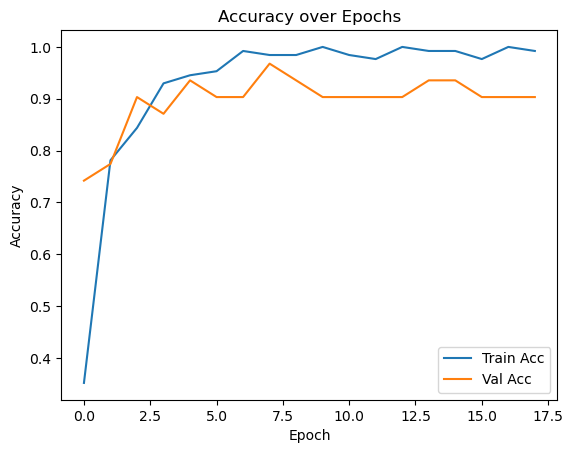

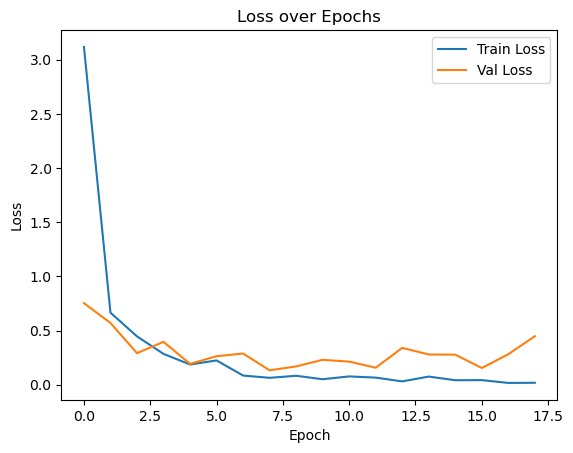

In [34]:
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

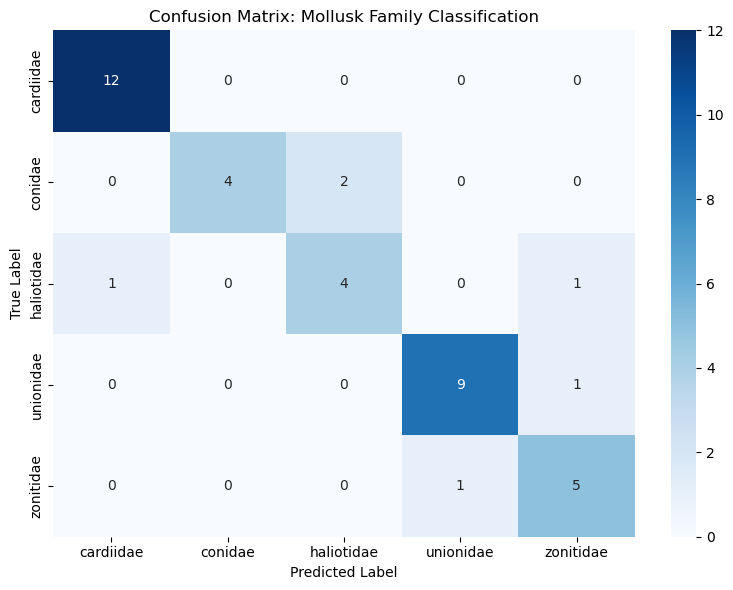

In [35]:
# Get true labels from test generator
true_labels = test_generator.classes
class_indices = test_generator.class_indices
class_names = list(class_indices.keys())

# Predict on test data
y_pred_probs = model2.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(true_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix: Mollusk Family Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [36]:
# Save
model.save("models/mollusca_models/best_mobilenetv2_combo.keras")
print("Model saved to models/mollusca_models/best_mobilenetv2_combo.keras")

Model saved to models/mollusca_models/best_mobilenetv2_combo.keras


# 7. Test the Models <a class="anchor" id="test"></a>

## 7.1. Test Custom Sequential Model <a class="anchor" id="testcustomseq"></a>

## 7.2. Test MobileNetV2 <a class="anchor" id="testMobileNetV2"></a>

Found 128 validated image filenames belonging to 5 classes.
Found 31 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
Loaded model from models/mollusca_models/best_mobilenetv2_combo.keras
40/40 [==============================] - 6s 83ms/step - loss: 0.1845 - accuracy: 0.9500

 Test Accuracy: 0.9500
40/40 [==============================] - 5s 101ms/step

Classification Report:
              precision    recall  f1-score   support

   cardiidae       0.92      1.00      0.96        12
     conidae       1.00      1.00      1.00         6
  haliotidae       1.00      0.67      0.80         6
   unionidae       0.91      1.00      0.95        10
   zonitidae       1.00      1.00      1.00         6

    accuracy                           0.95        40
   macro avg       0.97      0.93      0.94        40
weighted avg       0.95      0.95      0.95        40



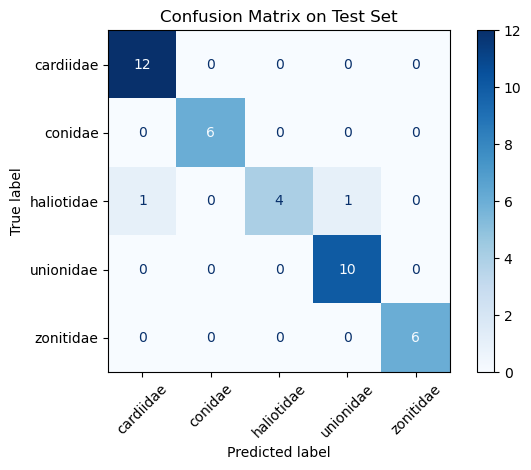

In [37]:
# Set model path and image size and batch size  
model_path = "models/mollusca_models/best_mobilenetv2_combo.keras"
image_size = (224, 224)         # <- Set this to match the model's training size
batch_size = 1                  # Test one at a time, no shuffling

# Create test generator using same logic as training
_, _, test_generator = create_generators(image_size=image_size, batch_size=batch_size)

# Load the trained model
model = load_model(model_path)
print(f"Loaded model from {model_path}")

# Evaluate on test set 
loss, acc = model.evaluate(test_generator, verbose=1)
print(f"\n Test Accuracy: {acc:.4f}")

# Generate predictions 
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get class labels in correct order
class_indices = test_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}
target_names = [index_to_class[i] for i in range(len(index_to_class))]

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()


Found 2 misclassified images.


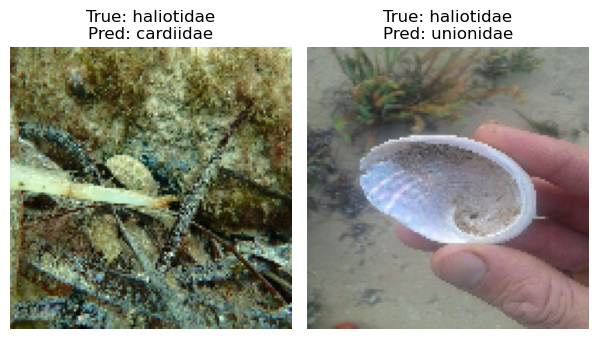

In [39]:
# 1. Get predictions
y_pred_probs = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# 2. Get misclassified indices
misclassified_indices = np.where(y_pred != y_true)[0]

print(f"Found {len(misclassified_indices)} misclassified images.")

# 3. Plot a few misclassified images
num_to_plot = min(10, len(misclassified_indices))  # Limit to 10 for visualization

plt.figure(figsize=(15, 10))

for i, idx in enumerate(misclassified_indices[:num_to_plot]):
    img_path = mollusca_test.iloc[idx]['filepath']
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img) / 255.0  # Normalize for display

    plt.subplot(2, 5, i+1)
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}")

plt.tight_layout()
plt.show()
